In [1]:
from utils.libs import *

In [2]:
conf_file_path = 'conf.txt'
conf_data = read_conf_file(conf_file_path)

pprint(conf_data)

{'columns_df_str': '#params;seed;hl;hf;mse;psnr;ssim;eta',
 'cropped_image': {'crop_size': '(256, 256)', 'flag': False},
 'images': [{'cropped_image': {'crop_size': '(256, 256)', 'flag': False}}],
 'is_single_run': True,
 'result_file_path': 'C:\\Users\\Francesco\\Documents\\tests\\siren-tests\\siren-train-logs\\cameramen\\23-10-2020\\1603410154-248962\\results.txt',
 'result_timestamp': 'None',
 'results_file_paths': ['C:\\Users\\Francesco\\Documents\\tests\\siren-tests\\siren-train-logs\\cameramen\\23-10-2020\\1603410154-248962\\results.txt',
                        'C:\\Users\\Francesco\\Documents\\tests\\siren-tests\\siren-train-logs\\cameramen\\23-10-2020\\1603478755-305517\\results.txt'],
 'results_timestamps': ['1603410154-248962', '1603478755-305517']}


In [3]:
if conf_data['is_single_run']:
    train_df = get_dataframe(conf_data)
else:
    result_dict_df = get_dict_dataframes(conf_data)
    train_df: pd.DataFrame = result_dict_df['1603410154-248962']
    pass

In [4]:
train_df.head(5)

,#params,seed,hl,hf,mse,psnr,ssim,eta
0,21057.0,0.0,5.0,64.0,0.000041,49.973107,0.995740,1196.407052
1,21057.0,42.0,5.0,64.0,0.000045,49.308277,0.995352,1191.496831
2,29377.0,0.0,7.0,64.0,0.000048,47.985887,0.996788,1461.727319
3,29377.0,42.0,7.0,64.0,0.000019,53.524139,0.997652,1493.893317
4,37697.0,0.0,9.0,64.0,0.000011,55.404166,0.998241,1792.826098


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   #params  6 non-null      float64
 1   seed     6 non-null      float64
 2   hl       6 non-null      float64
 3   hf       6 non-null      float64
 4   mse      6 non-null      float64
 5   psnr     6 non-null      float64
 6   ssim     6 non-null      float64
 7   eta      6 non-null      float64
dtypes: float64(8)
memory usage: 512.0 bytes


In [6]:
train_df.describe()

,#params,seed,hl,hf,mse,psnr,ssim,eta
count,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.000000,6.000000
mean,29377.000000,21.000000,7.000000,64.0,0.000036,50.939957,0.996859,1489.995021
std,7441.634229,23.004347,1.788854,0.0,0.000017,2.869434,0.001126,270.620142
min,21057.000000,0.000000,5.000000,64.0,0.000011,47.985887,0.995352,1191.496831
25%,23137.000000,0.000000,5.500000,64.0,0.000025,49.342249,0.996002,1262.737118
50%,29377.000000,21.000000,7.000000,64.0,0.000043,49.708635,0.997086,1477.810318
75%,35617.000000,42.000000,8.500000,64.0,0.000047,52.636381,0.997585,1718.092903
max,37697.000000,42.000000,9.000000,64.0,0.000051,55.404166,0.998241,1803.619511


Image size: (512, 512)


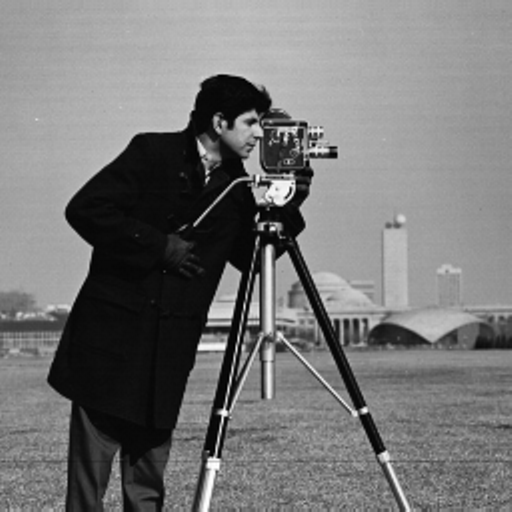

In [7]:
# Load target image.
im = load_target_image(image_file_path = None)
print('Image size:', im.size)
im

In [8]:
crop_size = conf_data['cropped_image']['crop_size']
if isinstance(crop_size, str):
    crop_size = eval(crop_size)
elif isinstance(crop_size, int):
    crop_size = (crop_size, crop_size)
    pass
type(crop_size[0])

int

Image size: (512, 512)


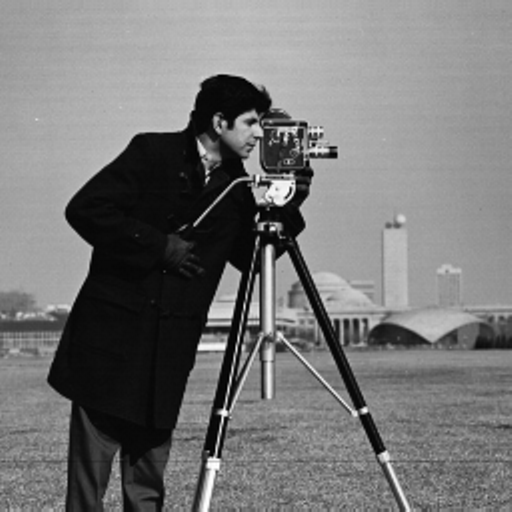

In [9]:
if conf_data['cropped_image']['flag'] is True:
    im_cropped = get_cropped_by_center_image(im, target = crop_size)
    pass
else:
    im_cropped = im
print('Image size:', im_cropped.size)
im_cropped

In [10]:
# Array of qualities to be tested in compression.
qualities_arr = np.arange(20, 95+1, dtype = np.int)

In [11]:
# Run several trials for JPEG compression.

cropped_file_size_bits = None

# im_cropped = im
# im_cropped = Image.fromarray(skimage.data.camera())
with BytesIO() as f:
    im_cropped.save(f, format='PNG')
    cropped_file_size_bits = f.getbuffer().nbytes * 8
    pass

result_tuples, failure_qualities = \
  calculate_several_jpeg_compression(im_cropped, cropped_file_size_bits, qualities_arr)

In [12]:
# data = list(map(lambda xx: xx._asdict(), result_tuples))
data = list(map(operator.methodcaller('_asdict'), result_tuples))
result_jpeg_df = pd.DataFrame(data = data)
result_jpeg_df.head(5)

,psnr,quality,file_size_bits,bpp,width,heigth,CR
0,34.736878,20,88800,0.338745,512,512,10.470541
1,34.951488,21,91568,0.349304,512,512,10.154028
2,35.139054,22,94080,0.358887,512,512,9.882908
3,35.367639,23,96232,0.367096,512,512,9.661900
4,35.549608,24,98584,0.376068,512,512,9.431388


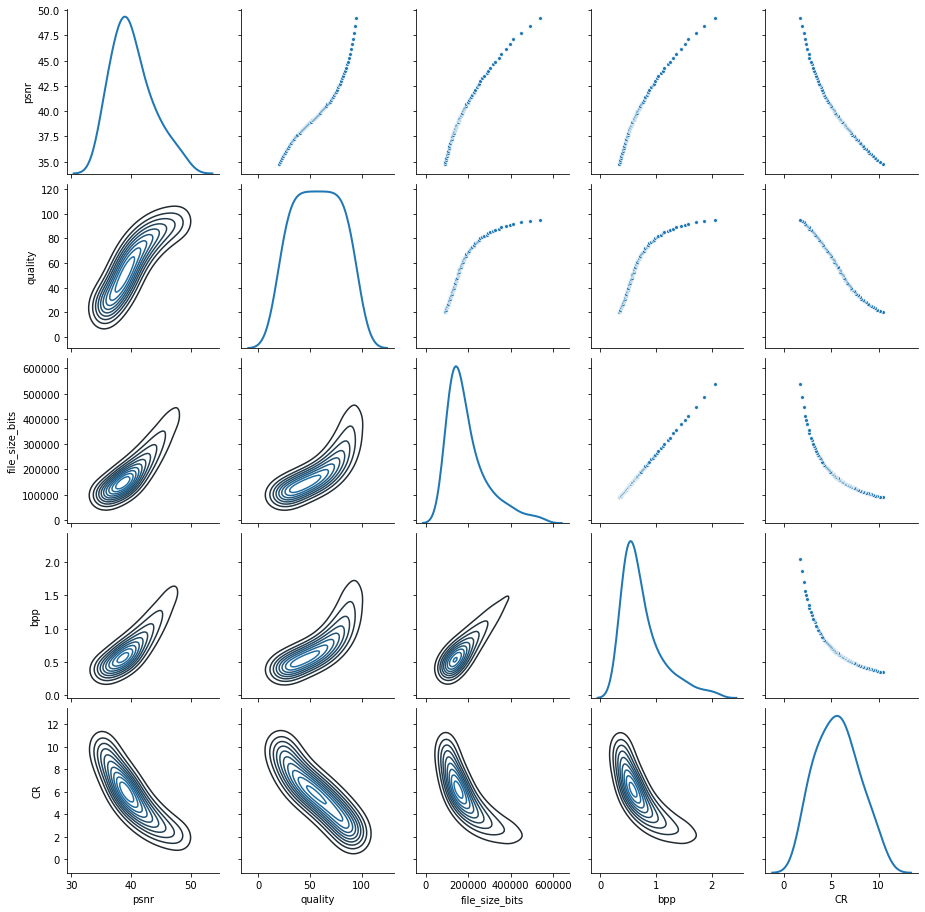

In [13]:
# sns.pairplot(results_history_df)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        g = sns.PairGrid(result_jpeg_df.drop(['width', 'heigth'], axis = 1), diag_sharey=False)
        g.map_upper(sns.scatterplot, s=15) # 
        g.map_lower(sns.kdeplot)
        g.map_diag(sns.kdeplot, lw=2)
        # plt.savefig(f"{images_conf.df_jpeg_scatterplot}")
    except Exception as err:
        print(str(err))
        pass
    pass

In [14]:
train_df['bpp'] = train_df['#params'].values * 32 / (im_cropped.size[0] * im_cropped.size[1])

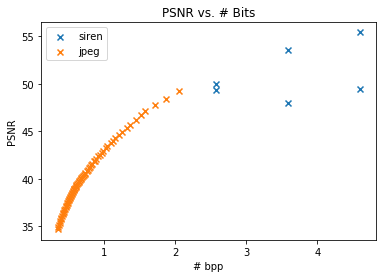

In [15]:
compare_compressions(compression_1_df=train_df, compression_2_df=result_jpeg_df)